# Testing the Simplified Betts-Miller scheme in a 2D model

The scheme is described by [Frierson (2007), J. Atmos. Sci. 64, doi:10.1175/JAS3935.1](https://doi.org/10.1175/JAS3935.1).

This is a work in progress to wrap the Fortran code from Dargan Frierson into a climlab process.

In this notebook, I set up a 2D zonally averaged model with the following processes:

- Annual mean insolation
- Longwave and Shortwave radiation
- Surface turbulent fluxes of sensible and latent heat
- Moist convection

## Building from source

For now, this what you have to do to install and use the code. First, get yourself a copy of the [source repo on github](https://github.com/brian-rose/climlab-sbm-convection). Then do the following.

### Build environment

Here are instructions to create a build environment (including Fortran compiler) with conda/mamba

Starting from the root of the `climlab-sbm-convection` repo *(example for Apple M1 machine, see `./ci/` for other environment files)*:
```
mamba create --name sbm_build_env python=3.10 --channel conda-forge
mamba env update --file ./ci/requirements-macos-arm64.yml
conda activate sbm_build_env
```

### Building with f2py

From the root of the repository, do this:
```
f2py -c -m _simplified_betts_miller climlab_betts_miller.f90
```

This will create the shared object `_simplified_betts_miller.cpython-*.so` that can be imported in a Python session.

_This is a work in progress, and eventually there will be better packaging so this manual build step will not be needed._

### Runtime environment for this notebook

See [here](https://github.com/brian-rose/ClimateLaboratoryBook/blob/main/environment.yml) for a conda environment file that specifies everything needed for this notebook.

## Build the model from components

In [1]:
import climlab
from simplified_betts_miller import SimplifiedBettsMiller
import numpy as np
import matplotlib.pyplot as plt

/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [2]:
# A two-dimensional domain
num_lev = 30
num_lat = 60
full_state = climlab.column_state(num_lev=num_lev, num_lat=num_lat, water_depth=10.)
lev = full_state.Tatm.domain.axes['lev'].points
qStrat = 5.E-6

# Use Manabe's profile as an initial condition for specific humidity
Q = full_state['Tatm'].domain.axes['lev'].points / climlab.utils.constants.ps
RHprofile = 0.7 * ((Q-0.02) / (1-0.02))
e = climlab.utils.thermo.clausius_clapeyron(full_state['Tatm']) * RHprofile
qStrat = 5.E-6
#qinitial = np.maximum(qStrat, e/full_state['Tatm'].domain.axes['lev'].points * climlab.utils.constants.Rd / climlab.utils.constants.Rv)
qinitial = 0.*full_state.Tatm + qStrat

full_state['q'] = qinitial
temperature_state = {'Tatm':full_state.Tatm,'Ts':full_state.Ts}
surface_state = {'Ts': full_state.Ts}

In [3]:
short_timestep=climlab.utils.constants.seconds_per_hour
long_timestep = climlab.utils.constants.seconds_per_day

#  Annual mean insolation as a function of latitude and time of year
sun = climlab.radiation.AnnualMeanInsolation(name='Insolation',
                                             domains=full_state['Ts'].domain,
                                             timestep=long_timestep,
                                            )

#  Convection scheme -- water vapor is a state variable
conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             timestep=short_timestep,  # SBM convection scheme seems to require a short timestep to avoid some instabilities
                            )  
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=temperature_state, 
                              specific_humidity=full_state['q'], 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              timestep=long_timestep,
                              )
atm = climlab.couple([rad, conv], name='Atmosphere')

shf = climlab.surface.SensibleHeatFlux(name='SHF',
                                       state=temperature_state, 
                                       Cd=0.5E-3, 
                                       timestep=long_timestep,)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                                     state=full_state, 
                                     Cd=0.5E-3, 
                                     timestep=long_timestep,)
# diff = climlab.dynamics.MeridionalHeatDiffusion(name='Ocean heat transport',
#                                                 state=surface_state, 
#                                                 D=0.555, 
#                                                 timestep=timestep)

#surface = climlab.couple([shf,lhf,diff], name="Slab")
surface = climlab.couple([shf,lhf], name="Slab")

moistmodel = climlab.couple([sun,atm,surface], name='2D Radiative-Convective model')

print(moistmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (60, 30) 
  Ts: (60, 1) 
  q: (60, 30) 
The subprocess tree: 
2D Radiative-Convective model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/radiation/radiation.py:156: UserWarning: Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.
  warnings.warn('Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.')


## Run the model and visualize

In [4]:
moistmodel.step_forward()

In [5]:
def plot_state(model):
    fig, ax = plt.subplots()
    model.Tatm.to_xarray().plot(x='lat',y='lev', yincrease=False)
    CSq = (model.q*1000).to_xarray().plot.contour(x='lat',y='lev', yincrease=False)
    ax.clabel(CSq)
    RH = model.q / climlab.utils.thermo.qsat(model.Tatm, model.lev) * 100
    CSrh = RH.to_xarray().plot.contour(x='lat',y='lev', yincrease=False, colors='w')
    ax.clabel(CSrh)
    return fig, ax

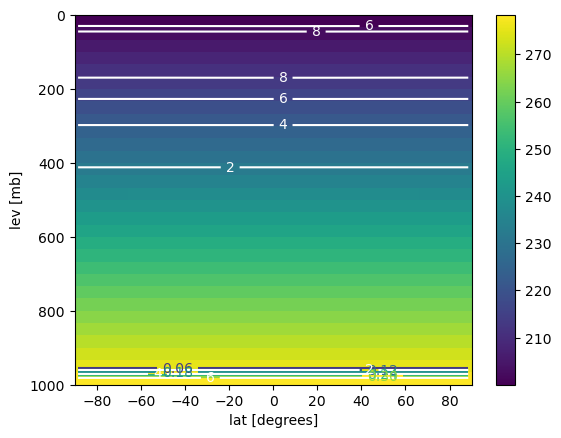

In [6]:
fig, ax = plot_state(moistmodel)

In these plots the colors are air temperature, the colored contours are specific humidity in g/kg, and the white contours are relative humidity in percent.

In [7]:
moistmodel.integrate_days(10)

Integrating for 239 steps, 10.0 days, or 0.027379092558307883 years.
Total elapsed time is 0.027379092558307862 years.


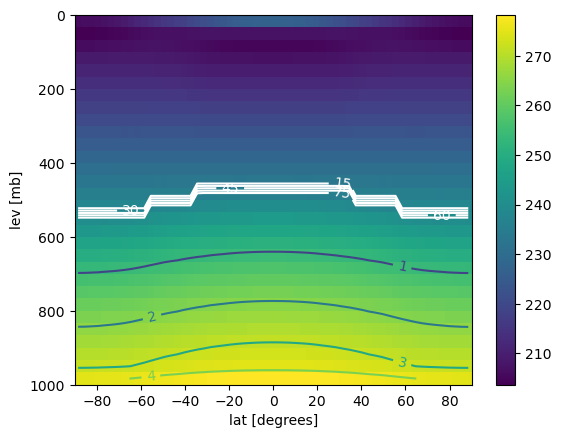

In [8]:
fig, ax = plot_state(moistmodel)

In [9]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.0272863686982616 years.


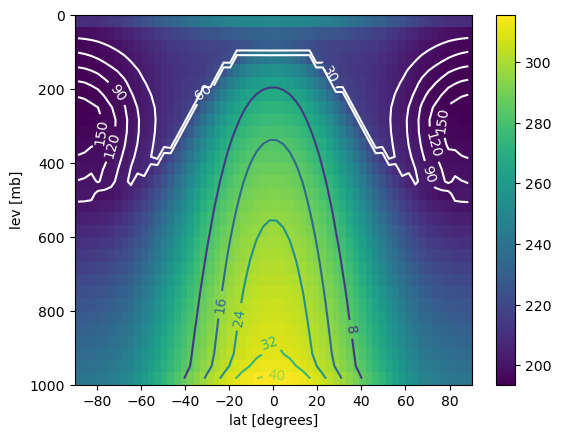

In [10]:
fig, ax = plot_state(moistmodel)

Here we can see the spatial structure of air temperature and specific humidity emerging from the interaction of insolation, radiation, surface fluxes, and the moist convection scheme.

This model has no meridional heat transport, so develops a very hot equator and cold pole.

In [11]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.027193644837732 years.


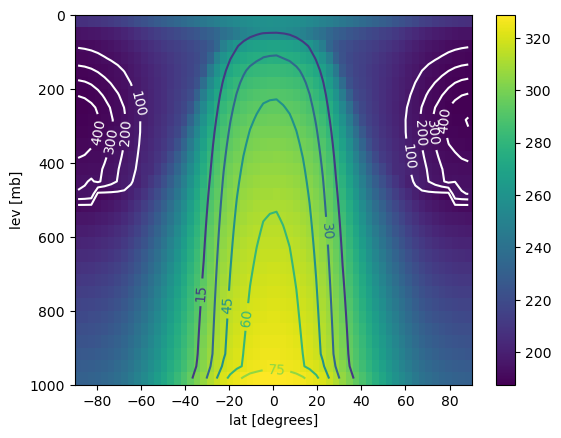

In [12]:
fig, ax = plot_state(moistmodel)

After another year of integration, the hot tropics / cold pole pattern becomes even clearer.

In [13]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.0271009209773014 years.


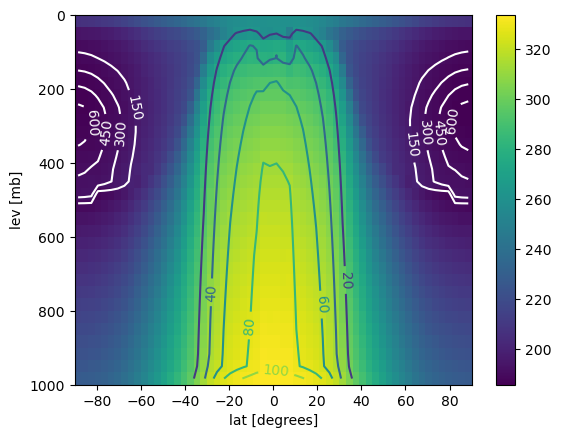

In [14]:
fig, ax = plot_state(moistmodel)

The problem that emerges here is that the air can become extremely supersaturated, as shown by the white relative humidity contours. In the absence of convection, there is no condensation process returning the specific humidity to saturation.

This model requires a new process to represent large-scale condensation. This will become particularly important when we implement diffusive moisture transport. In regions of moisture convergence, there needs to be a process removing water vapor through condensation (and associated latent heating of the air temperature).

## Add some meridional heat transport

Sidestepping (for now) the problem of large-scale condensation, we can add some meridional temperature diffusion to the model and thereby moderate the temperature gradients.

In [15]:
dynamicmodel = climlab.process_like(moistmodel)

# thermal diffusivity in W/m**2/degC
D = 0.04
# meridional diffusivity in m**2/s
K = D / dynamicmodel.Tatm.domain.heat_capacity[0] * climlab.utils.constants.a**2
d = climlab.dynamics.MeridionalDiffusion(state={'Tatm': dynamicmodel.state['Tatm']}, 
                        K=K, timestep=long_timestep)
dynamicmodel.subprocess['Atmosphere'].add_subprocess('Heat Diffusion', d)

print(dynamicmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (60, 30) 
  Ts: (60, 1) 
  q: (60, 30) 
The subprocess tree: 
2D Radiative-Convective model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
      Heat Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <class 'climlab.sur

In [16]:
# First just check to see if we can take a single step
dynamicmodel.step_forward()

Just a few days of integration is enough to show the moderating effect of the diffusion:

In [17]:
dynamicmodel.integrate_days(10)

Integrating for 239 steps, 10.0 days, or 0.027379092558307883 years.
Total elapsed time is 3.054480013535659 years.


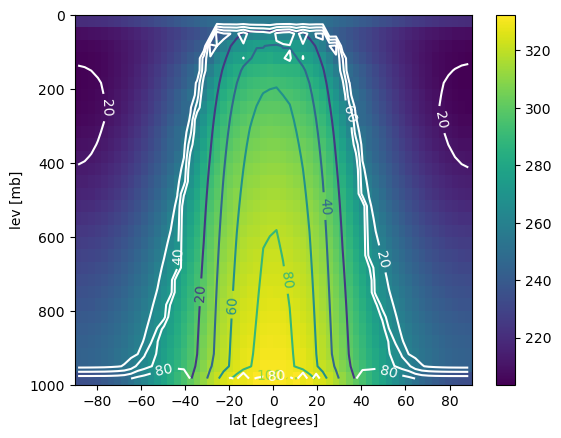

In [18]:
fig, ax = plot_state(dynamicmodel)

The supersaturation problem went away here because we warmed up the air sufficiently.

Unfortunately there are some numerical issues that arise:

Integrating for 1007 steps, 42.0 days, or 0.1149921887448931 years.
Total elapsed time is 3.169358122728435 years.


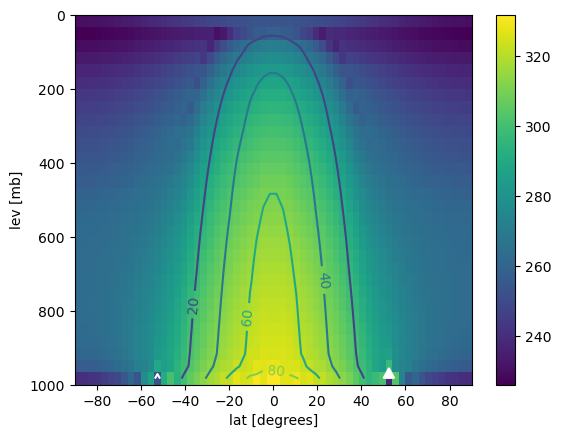

In [19]:
dynamicmodel.integrate_days(42)
fig, ax = plot_state(dynamicmodel)

There are some numerical artifacts in the near-surface air temperature:

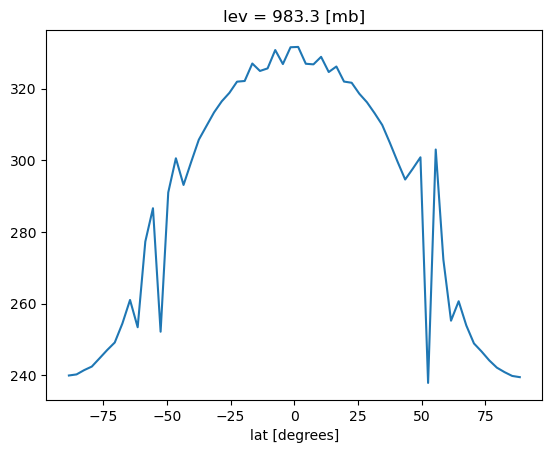

In [20]:
dynamicmodel.Tatm.to_xarray()[:,-1].plot()

A few more timesteps and the model will blow up.

In [21]:
dynamicmodel.integrate_days(1)

Integrating for 23 steps, 1.0 days, or 0.002737909255830788 years.
Total elapsed time is 3.171981952431944 years.


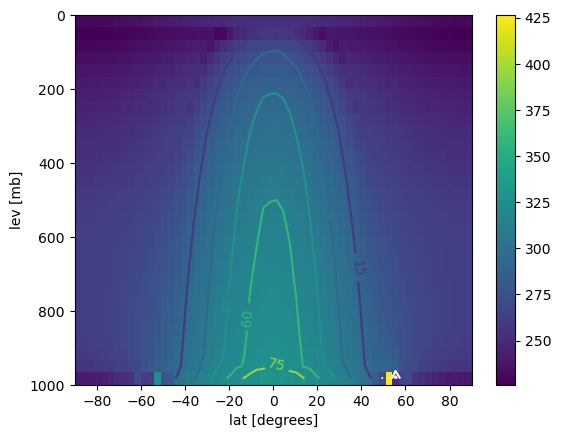

In [22]:
fig, ax = plot_state(dynamicmodel)

## Next steps

I'm not clear on what's causing the instability. However this model is physically inconsistent, because we have a prognostic humidity but the diffusive transport is only acting on temperature.

A self-consistent 2D diffusive model would need:

1. Diffusion acting on humidity as well as temperature
2. Large-scale condensation process removing humidity as precipitation and warming the air temperature wherever supersaturation occurs.

Item 1 can be readily implemented with the existing `climlab.dynamics.MeridionalDiffusion` process.

Item 2 requires a new process that computes saturation specific humidity at each grid point and implements a restoring tendency on the specific humidity, along with required latent heating of the air temperature.

## Large-scale Condensation process

Create a new Process class that does the following at each timestep:

- Calculate saturation specific humidity given air temperatures at every grid point
- Calculate supersaturation by comparing actual specific humidity to saturation specific humidity
- Compute a specific humidity tendency based on a relaxation toward saturation (if supersaturated)
- Compute a heating rate and temperature tendency due to the latent heating of condensation
- Compute precipitation rate at the surface, assuming all condensate in each column is instantly precipitated

### State variables

- Air temperature `Tatm`
- Specific humidity `q`

### Diagnostics

- Latent heating rate (every grid cell) `latent_heating`
- Precipitation rate `precipitation`

### Condensation formula

The condensation rule follows the SPEEDY model [(Molteni 2003 doi:10.1007/s00382-002-0268-2)](https://doi.org/10.1007/s00382-002-0268-2). Condensation is modeled as a relaxation of relative humidity toward a specified profile wherever the tropospheric relative humidity exceeds the target.

Given specific humidity $q$ and saturation specific humidity $q_{sat}(T,p)$, relative humidity is calculated from

$$r = \frac{q}{q_{sat}} $$

which is compared against a specified reference profile $r_{lsc}$ which may vary spatially.

At grid cells where $r > r_{lsc}$, the specific humidity tendency is calculated from

$$ \left(\frac{\partial q}{\partial t}\right)_{lsc} = -\frac{(q - r_{lsc} q_{sat})}{\tau_{lsc}} $$

and is zero otherwise.

The two parameters of the scheme are the relaxation time constant $\tau_{lsc}$ and the reference RH profile $r_{lsc}$.

We will follow SPEEDY (at least for now) and set an "aggressive" time constant $\tau_{lsc} = 4 $ hours.

For the reference profile, SPEEDY sets a smoothly decreasing vertical profile with $r_{lsc} = 0.9$ at the surface and $r_{lsc} \approx 0.8$ at the tropopause. For simplicity, we will start with a uniform default value of $r_{lsc} = 0.9$.

The temperature tendency due to latent heating (in units of K s$^{-1}$) is calculated from

$$ \left(\frac{\partial T}{\partial t}\right)_{lsc} = -\frac{L}{c_p} \left(\frac{\partial q}{\partial t}\right)_{lsc}  $$

with the associated heating rate diagnostic (in units of W m$^{-2}$) computed from

$$ h_{lsc} = C \left(\frac{\partial T}{\partial t}\right)_{lsc} $$

where $C = \frac{c_p dp}{g}$ is the heat capacity per unit area in J K$^{-1}$ m$^{-2}$.

and the precipitation rate (in units of kg m$^{-2} s^{-1}$ or mm s$^{-1}$) is calculated from the vertical integral:

$$ P = -\frac{1}{g} \int_0^{p_0} \left(\frac{\partial q}{\partial t}\right)_{lsc} dp $$

or equivalently

$$ P = + \int_0^{p_0} \frac{h_{lsc}}{L} $$

where the integral implies a sum over all grid cells in each atmospheric column.

In [23]:
from climlab.process import TimeDependentProcess
from climlab.utils import constants as const
from climlab.utils.thermo import qsat


class LargeScaleCondensation(TimeDependentProcess):
    def __init__(self, 
                 condensation_time = 4*const.seconds_per_hour, 
                 RH_ref = 0.9,
                 **kwargs):
        super(LargeScaleCondensation, self).__init__(**kwargs)
        self.condensation_time = condensation_time
        self.RH_ref = RH_ref
        self.add_diagnostic('latent_heating', 0.*self.Tatm)
        self.add_diagnostic('precipitation', 0.*self.Ts)
        
    def _compute(self):
        qsaturation = qsat(self.Tatm, self.lev) 
        qtendency = -(self.q - self.RH_ref*qsaturation) / self.condensation_time

        tendencies = {}
        tendencies['q'] = np.minimum(qtendency, 0.)
        tendencies['Tatm'] = -const.Lhvap/const.cp * tendencies['q']
        self.latent_heating[:] = tendencies['Tatm'] * self.Tatm.domain.heat_capacity
        self.precipitation[:,0] = np.sum(self.latent_heating, axis=-1)/const.Lhvap
        return tendencies



This exposes a climlab limitation around diagnostics with same names:
https://github.com/climlab/climlab/issues/202

Here I'm defining a `precipitation` diagnostic which has the same name as the diagnostic produced by the convection scheme. Really they should be added together in the parent process. But I'll ignore this for now.

## Moisture diffusion

Let's set up a 2D model with radiation, diffusion, convective adjustment, and prescribed relative humidity.

We'll just use this to generate an initial condition for the more complex model with interactive hydrological cycle.

In [24]:
# A two-dimensional domain
num_lev = 30
num_lat = 60
temperature_state = climlab.column_state(num_lev=num_lev, num_lat=num_lat, water_depth=10.)

short_timestep=climlab.utils.constants.seconds_per_hour
long_timestep = climlab.utils.constants.seconds_per_day

#  Annual mean insolation as a function of latitude and time of year
sun = climlab.radiation.AnnualMeanInsolation(name='Insolation',
                                             domains=temperature_state['Ts'].domain,
                                             timestep=long_timestep,
                                            )
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(name='Specified Relative Humidity',
                                         state=temperature_state,
                                        timestep=long_timestep)

#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=temperature_state,
                                               adj_lapse_rate=6.5,
                                               timestep=long_timestep)

#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=temperature_state, 
                              specific_humidity=h2o.q, 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              timestep=long_timestep,
                              )

# thermal diffusivity in W/m**2/degC
D = 0.04
# meridional diffusivity in m**2/s
K = D / dynamicmodel.Tatm.domain.heat_capacity[0] * climlab.utils.constants.a**2
d = climlab.dynamics.MeridionalDiffusion(name='Temperature Diffusion',
                                         state={'Tatm': temperature_state['Tatm']},
                                         K=K, 
                                         timestep=long_timestep)

drymodel = climlab.couple([sun,h2o,conv,rad,d], name='Dry diffusion model')
print(drymodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 30) 
The subprocess tree: 
Dry diffusion model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Specified Relative Humidity: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Temperature Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/radiation/radiation.py:156: UserWarning: Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.
  warnings.warn('Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.')


In [25]:
drymodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

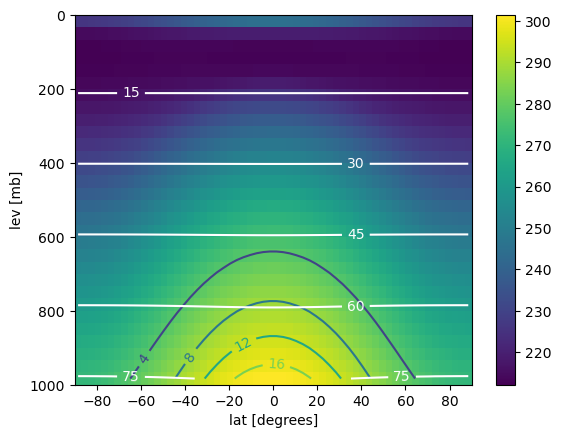

In [26]:
plot_state(drymodel)

This model has spatial gradients in temperature and specific humidity. The humidity structure is entirely determined by temperature, which is determined by heat diffusion along with radiation.

We're now going to start diffusing the humidity, and remove the process that keeps relative humidity pinned to a referenc profile.

We should see that the spatial gradients in humidity get smoothed out.

### Now add moisture diffusion

In [27]:
moistmodel1 = climlab.process_like(drymodel)
moistmodel1.name = 'Moist diffusion model'
moistmodel1.set_state('q', drymodel.q)
moistmodel1.remove_subprocess('Temperature Diffusion')
moistmodel1.remove_subprocess('Specified Relative Humidity')

md = climlab.dynamics.MeridionalDiffusion(name='Moist Diffusion',
                                         state={'Tatm':moistmodel1.Tatm, 'q':moistmodel1.q},
                                         K=K, 
                                         timestep=long_timestep)

moistmodel1.add_subprocess('Moist Diffusion', md)
print(moistmodel1)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 30) 
  q: (60, 30) 
The subprocess tree: 
Moist diffusion model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Moist Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



In [28]:
moistmodel1.step_forward()

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

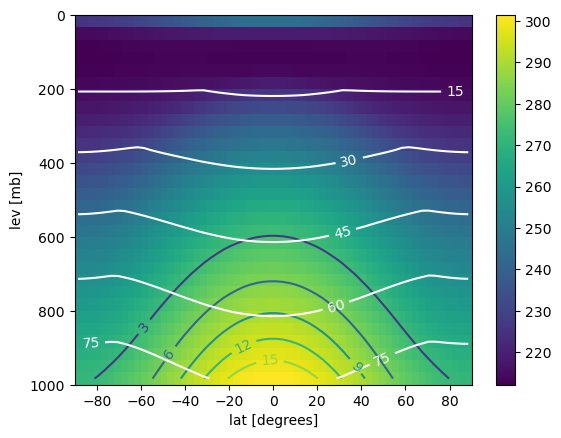

In [29]:
plot_state(moistmodel1)

Looks good after a single day!

In [30]:
moistmodel1.integrate_days(20)

Integrating for 20 steps, 20.0 days, or 0.05475818511661577 years.
Total elapsed time is 1.0568329727506842 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

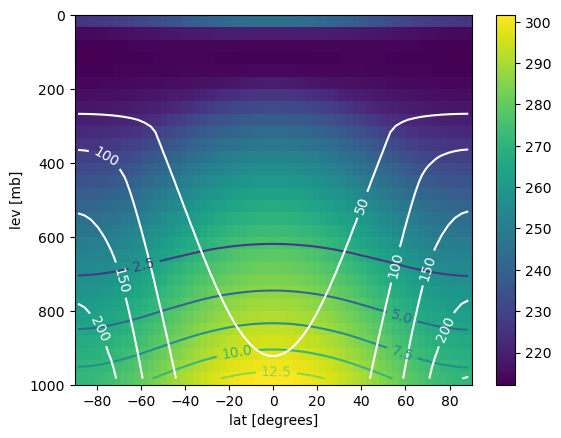

In [31]:
plot_state(moistmodel1)

This makes good sense. Specific humidity gradients are flattened out.

There is no large scale condensation process in here acting to remove supersaturation, so the high latitudes get strongly supersaturated due to moisture conveergence, while the tropics become relatively dry.

### Now add the condensation process

In [32]:
moistmodel2 = climlab.process_like(moistmodel1)
moistmodel2.name = 'Moist diffusion / condensation model'
lsc = LargeScaleCondensation(name='Large Scale Condensation',
                             state=moistmodel2.state,
                             timestep =long_timestep
                            )
moistmodel2.add_subprocess('Large Scale Condensation', lsc)
print(moistmodel2)
                             

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 30) 
  q: (60, 30) 
The subprocess tree: 
Moist diffusion / condensation model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Moist Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   Large Scale Condensation: <class '__main__.LargeScaleCondensation'>



In [33]:
moistmodel2.step_forward()

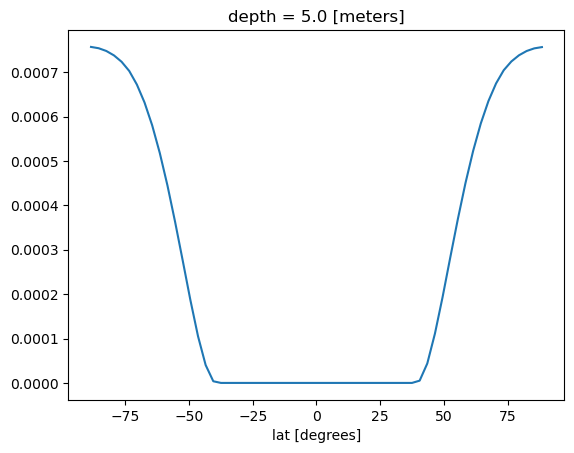

In [34]:
moistmodel2.precipitation.to_xarray().plot()

Condensation and precipitation seem sensible here.

If we keep running this, we are going to deplete the high latitude moisture.

In [35]:
moistmodel2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.058907760384753 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

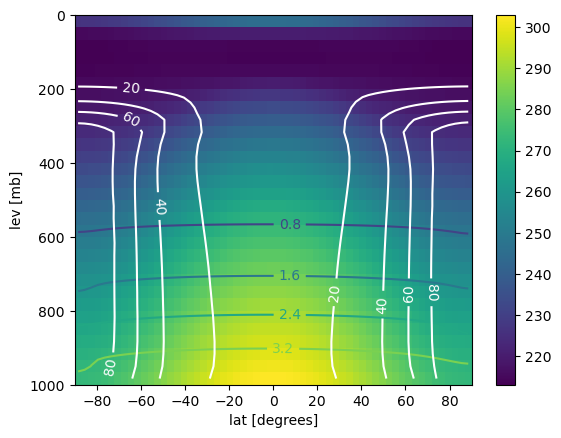

In [36]:
plot_state(moistmodel2)

Now with the condensation scheme active, we don't get any more supersaturation and the specific humidity is lower everywhere as there is no water vapor source.

### Now add surface evaporation

We will only moisten the surface this way since our convection scheme is dry, but let's take the next step and add the turbulent moisture flux.

In [37]:
moistmodel3 = climlab.process_like(moistmodel2)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                                     state=moistmodel3.state,
                                     Cd=0.5E-3, 
                                     timestep=long_timestep,)
moistmodel3.add_subprocess('LHF', lhf)
print(moistmodel3)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 30) 
  q: (60, 30) 
The subprocess tree: 
Moist diffusion / condensation model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Moist Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   Large Scale Condensation: <class '__main__.LargeScaleCondensation'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [38]:
moistmodel3.step_forward()

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

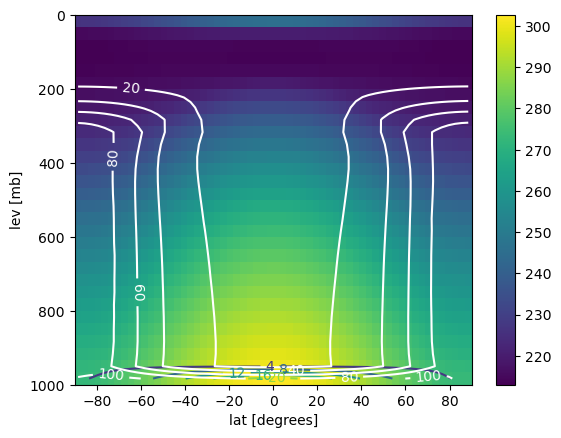

In [39]:
plot_state(moistmodel3)

In [40]:
moistmodel3.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.060982548018821 years.


In [41]:
moistmodel3.integrate_days(30)

Integrating for 30 steps, 30.000000000000004 days, or 0.08213727767492365 years.
Total elapsed time is 3.143119825693745 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

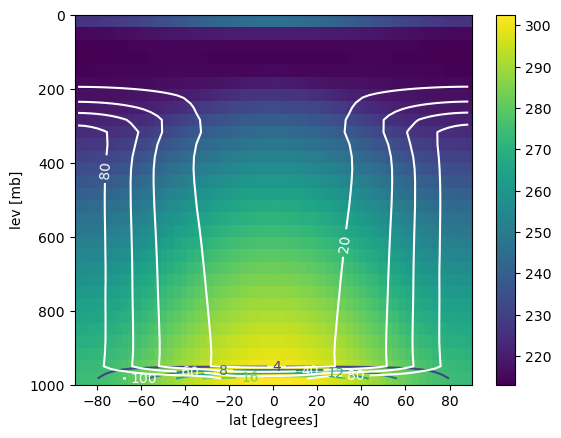

In [42]:
plot_state(moistmodel3)

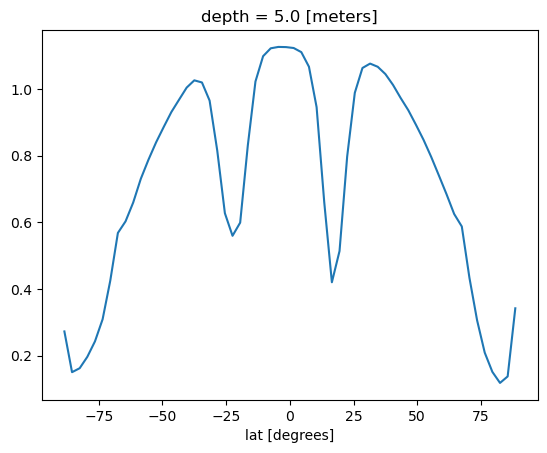

In [43]:
(moistmodel3.timeave['precipitation']*const.seconds_per_day).to_xarray().plot()

This is the time-averaged rain rate in mm / day.

Things look ok so far, but we need the convection to moisten above the surface.

## The full moist model with convection and closed hydrological cycle

Use one of the previous solutions as initial condition, but put together the full model correctly and use a short timestep for the convection scheme.

In [44]:
fullstate = moistmodel3.state.copy()
atmstate = {'Tatm': fullstate['Tatm'], 'q': fullstate['q']}
tempstate = {'Tatm': fullstate['Tatm'], 'Ts': fullstate['Ts']}

In [45]:
#  Annual mean insolation as a function of latitude and time of year
sun = climlab.radiation.AnnualMeanInsolation(name='Insolation',
                                             domains=fullstate['Ts'].domain,
                                             timestep=long_timestep,
                                            )

md = climlab.dynamics.MeridionalDiffusion(name='Moist Diffusion',
                                         state=atmstate,
                                         K=K, 
                                         timestep=long_timestep)

#  Convection scheme -- water vapor is a state variable
conv = SimplifiedBettsMiller(name='Convection',
                             state=atmstate,
                             timestep=short_timestep,  # SBM convection scheme seems to require a short timestep to avoid some instabilities
                            )  
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=tempstate, 
                              specific_humidity=fullstate['q'], 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              timestep=long_timestep,
                              )
atm = climlab.couple([rad, conv, md], name='Atmosphere')

shf = climlab.surface.SensibleHeatFlux(name='SHF',
                                       state=tempstate, 
                                       Cd=0.5E-3, 
                                       timestep=long_timestep,)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                                     state=fullstate, 
                                     Cd=0.5E-3, 
                                     timestep=long_timestep,)


surface = climlab.couple([shf,lhf], name="Slab")

fullmodel = climlab.couple([sun,atm,surface], name='2D Moist Radiative-Convective-Diffusive model')

print(fullmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (60, 30) 
  Ts: (60, 1) 
  q: (60, 30) 
The subprocess tree: 
2D Moist Radiative-Convective-Diffusive model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
      Moist Diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <c

/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/radiation/radiation.py:156: UserWarning: Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.
  warnings.warn('Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.')


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

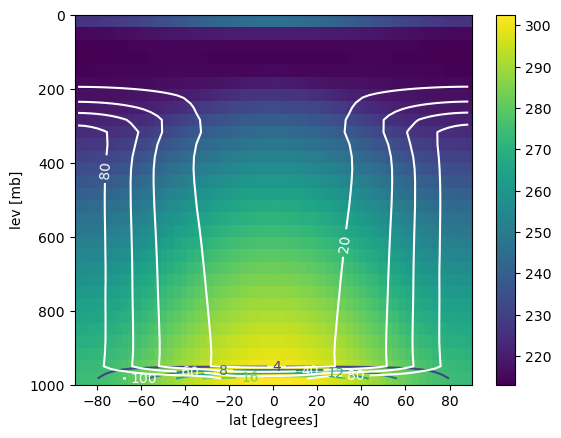

In [46]:
plot_state(fullmodel)

In [47]:
fullmodel.step_forward()

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

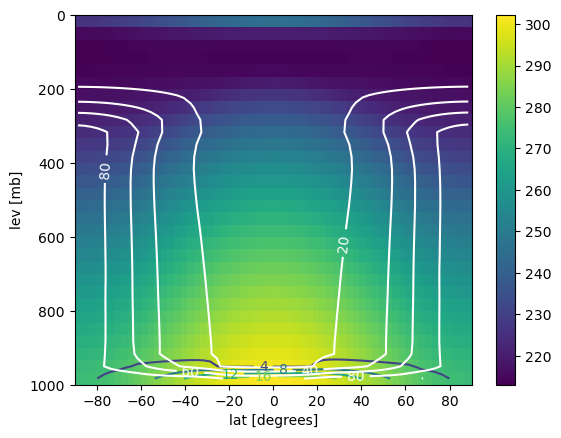

In [48]:
plot_state(fullmodel)

In [49]:
fullmodel.integrate_days(2)

Integrating for 47 steps, 2.0 days, or 0.005475818511661576 years.
Total elapsed time is 0.00547581851166158 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

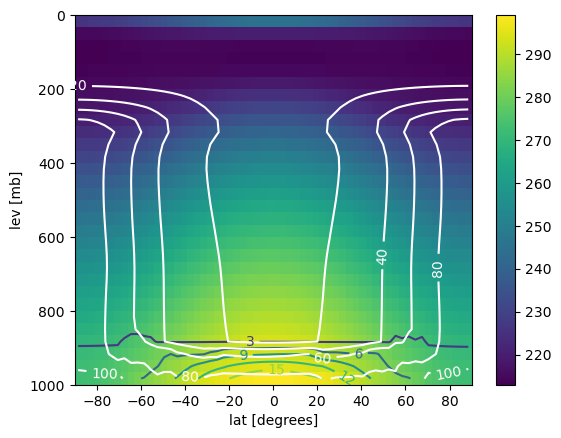

In [50]:
plot_state(fullmodel)

In [51]:
fullmodel.integrate_days(40)

Integrating for 959 steps, 40.0 days, or 0.10951637023323153 years.
Total elapsed time is 0.11487810919256626 years.


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='lat [degrees]', ylabel='lev [mb]'>)

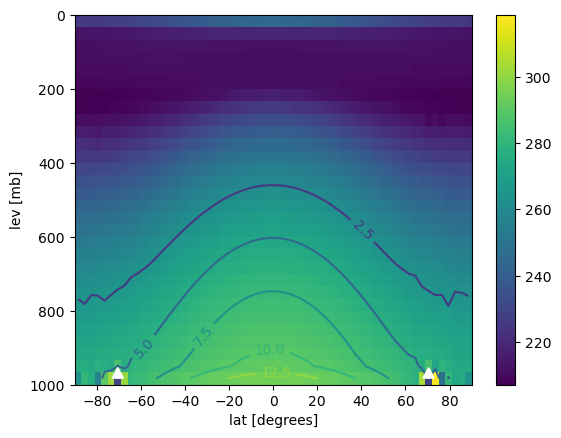

In [52]:
plot_state(fullmodel)

Still some issues with numerical instabilities here.